In [5]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn                               # layers
import torch.nn.functional as F
import torch.optim as optim                         # optimizer
import torchvision.datasets as ds                   # mnist daataset
import torchvision.transforms as transforms         # image -> tensor
from torch.utils.data import DataLoader, Dataset    # torch dataset

import matplotlib.pyplot as plt                     # 시각화
import seaborn as sns
import plotly.express as px

## MLP

퍼셉트론으로 이루어진 layer 여러 개를 순차적으로 붙여 놓음



### GPU 확인
해당 시스템에서 gpu를 사용이 가능한지 확인

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Seed 고정

실험 재현을 위한 난수 고정

In [4]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

### Hyperparameter 설정

- Hyperparameter: 모델에서 학습되지 않는 사용자가 직접 설정해야하는 파라미터
<br>
<br>
    - batch_size: 전체 데이터 중 데이터를 몇 개의 묶음으로 분할한 건지 설정
    - epoch: 학습을 몇 번 진행할 것인가
    - learning_rate: 얼마 만큼의 보폭으로 학습을 진행할 것인가

In [5]:
batch_size = 32
epochs = 100
learning_rate = 1e-2

### 데이터 전처리

In [6]:
def load_planar_dataset():
    np.random.seed(1) # 랜덤 시드 설정으로 결과 재현 가능
    m = 400 # 전체 샘플 수
    N = int(m/2) # 각 클래스 당 샘플 수
    D = 2 # 데이터의 차원(2D 평면)
    X = np.zeros((m, D)) # 데이터 행렬: 각 행은 하나의 샘플
    Y = np.zeros((m, 1), dtype = 'uint8') # 레이블 벡터: 0은 빨강, 1은 파랑
    a = 4 # 꽃 모양의 최대 반지름

    for j in range(2):  # 두 클래스에 대해 반복
        ix = range(N*j,N*(j+1))  # 현재 클래스의 인덱스 범위
        # 극좌표계에서 각도 생성 (약간의 랜덤 노이즈 추가)
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2  # theta
        # 반지름 계산 (사인 함수 사용, 랜덤 노이즈 추가)
        r = a*np.sin(4*t) + np.random.randn(N)*0.2  # radius
        # 극좌표를 직교좌표로 변환하여 X에 저장
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j  # 현재 클래스의 레이블 할당

    return X, Y  # 생성된 데이터셋 반환

In [7]:
X, y = load_planar_dataset()

### 결측치 중복 처리

In [8]:
# X, y 데이터를 이용하여 pandas DataFrame 생성
data = pd.DataFrame(X, columns=['x1','x2']) # X 데이터로 DataFrame 생성, 열 이름은 'x1'과 'x2'로 지정
data['y'] = y # y 데이터를 새로운 열 'y'로 추가

# 결측치(NA) 개수 확인 및 출력
print(f'num of na: {data.isna().sum()}')  # isna()로 결측치 확인 후 sum()으로 개수 집계

# 중복 데이터 개수 확인 및 출력
print(f'num of duplicated: {data.duplicated().sum()}')  # duplicated()로 중복 확인 후 sum()으로 개수 집계

num of na: x1    0
x2    0
y     0
dtype: int64
num of duplicated: 0


#### train, valid, test split

<img src="https://camo.githubusercontent.com/109b64cb7b6e1b6d912b84a1b6afefa53300033be1df4ed8c4433910f8c328bf/68747470733a2f2f76656c6f672e76656c63646e2e636f6d2f696d616765732f696775762f706f73742f38616538343265332d663262362d343463352d623762662d6131663734623361393132342f696d6167652e706e67" width="500" height="300"/>

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=seed
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed
)

In [10]:
len(X_train), len(X_valid), len(X_test)

(240, 80, 80)

### scaler 적용

일반화 성능을 위해서 적용

In [11]:
standard_scaler_x = StandardScaler()
X_train = standard_scaler_x.fit_transform(X_train)
X_valid = standard_scaler_x.transform(X_valid)
X_test = standard_scaler_x.transform(X_test)

### DataSet

DataLoader에서 불러올 데이터의 '형식'을 지정하는 class. <br>
__getitem__의 idx는 전체 데이터의 인덱스를 임의로 추출. <br>
def __len__(self)에서 정의된 데이터의 크기를 사용하기 때문에 '반드시 정의'해야함. <br>
 <br>
**Datasets class**를 상속받아 구현

In [12]:
class PlanarDataset(Dataset):
    def __init__(self, X, y):
        super().__init__
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(self.y[idx]).float()

        return X, y

In [13]:
train_dataset = PlanarDataset(X_train, y_train)
valid_dataset = PlanarDataset(X_valid, y_valid)
test_dataset = PlanarDataset(X_test, y_test)

In [14]:
train_dataset[0]

(tensor([1.5398, 0.8657]), tensor([1.]))

## DataLoader

In [15]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

In [16]:
X, y = list(train_dataloader)[0]

In [17]:
X.shape

torch.Size([32, 2])

## 모델 구조 정의

- 모형 복잡도에 비해 데이터 수가 적으면 오버피팅 발생 높음 / 많으면 언더피팅 발생 높음
- **nn.Module**을 상속받아 구현

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        x = self.sigmoid(x)

        return x

## 모델 선언

In [19]:
mlp = MLP(2, 4, 1).to(device)

In [20]:
mlp

MLP(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (tanh): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Loss, Optimizer 정의

- loss: 정답과 모델 예측 값의 차이 계산
- optimizer: parameter를 update할 로직 설정

In [21]:
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(mlp.parameters(), learning_rate)

## Train, Validation

In [24]:
train_losses, train_accs = [], []
valid_losses, valid_accs = [], []

for epoch in range(1, epochs+1):

    ###################### train ######################
    total_train_loss, total_train_acc = 0, 0

    mlp.train()                                 # 모델을 학습 모드로 설정
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()                   # 그래디언트 초기화
        logit = mlp(X)                          # 모델의 예측값 계산
        train_loss = criterion(logit, y)        # 손실 계산
        train_loss.backward()                   # 역전파 수행
        optimizer.step()                        # 모델 파라미터 업데이트

        predicted_label = torch.where(logit > 0.5, 1, 0)            # 예측 레이블 생성
        train_acc = (predicted_label == y).float().mean()           # 정확도 계산 

        total_train_loss += train_loss
        total_train_acc += train_acc

        # 평균 훈련 손실과 정확도 계산
        mean_train_loss = total_train_loss / len(train_dataloader)
        mean_train_acc = total_train_acc / len(train_dataloader)

        train_losses.append(mean_train_loss)
        train_accs.append(mean_train_acc)

        ##################### validation #####################
        total_valid_loss, total_valid_acc = 0, 0

        mlp.eval()                                      # 모델을 평가 모드로 설정
        with torch.no_grad():                           # 그래디언트 계산 비활성화
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)       # 데이터를 GPU로 이동

                logit = mlp(X)                          # 모델의 예측값 계산
                valid_loss = criterion(logit, y)        # 손실 계산

                predicted_label = torch.where(logit > 0.5, 1, 0)        # 예측 레이블 생성
                valid_acc = (predicted_label == y).float().mean()       # 정확도 계산
                total_valid_loss += valid_loss
                total_valid_acc += valid_acc
            
        # 평균 검증 손실과 정확도 계산
        mean_valid_loss = total_valid_loss / len(valid_dataloader)
        mean_valid_acc = total_valid_acc / len(valid_dataloader)
        valid_losses.append(mean_valid_loss)
        valid_accs.append(mean_valid_acc)

        # 에폭별 결과 출력
        print(f'Epoch: {epoch} | train_loss: {mean_train_loss:.4f} | train_acc: {mean_train_acc*100:.2f}% | valid_loss: {mean_valid_loss:.4f} | valid_acc: {mean_valid_acc*100:.2f}%')

Epoch: 1 | train_loss: 0.0574 | train_acc: 11.61% | valid_loss: 0.3647 | valid_acc: 85.94%
Epoch: 1 | train_loss: 0.1060 | train_acc: 23.66% | valid_loss: 0.3645 | valid_acc: 85.94%
Epoch: 1 | train_loss: 0.1468 | train_acc: 36.16% | valid_loss: 0.3642 | valid_acc: 85.94%
Epoch: 1 | train_loss: 0.1818 | train_acc: 49.55% | valid_loss: 0.3639 | valid_acc: 84.38%
Epoch: 1 | train_loss: 0.2489 | train_acc: 62.05% | valid_loss: 0.3639 | valid_acc: 85.94%
Epoch: 1 | train_loss: 0.2852 | train_acc: 75.45% | valid_loss: 0.3638 | valid_acc: 85.94%
Epoch: 1 | train_loss: 0.3477 | train_acc: 86.61% | valid_loss: 0.3636 | valid_acc: 85.94%
Epoch: 2 | train_loss: 0.0553 | train_acc: 12.05% | valid_loss: 0.3637 | valid_acc: 85.94%
Epoch: 2 | train_loss: 0.0905 | train_acc: 25.00% | valid_loss: 0.3637 | valid_acc: 85.94%
Epoch: 2 | train_loss: 0.1494 | train_acc: 36.61% | valid_loss: 0.3636 | valid_acc: 85.94%
Epoch: 2 | train_loss: 0.2024 | train_acc: 49.55% | valid_loss: 0.3635 | valid_acc: 85.94%

**Overfitting check**

<Axes: >

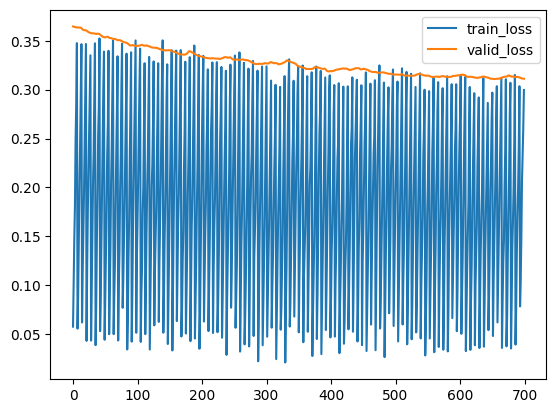

In [25]:
pd.DataFrame({
    'train_loss': [train_loss.item() for train_loss in train_losses],
    'valid_loss': [valid_loss.item() for valid_loss in valid_losses]
}).plot()

## Test

In [26]:
total_test_loss = 0 
total_test_acc = 0 

mlp.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        logit = mlp(X)                     # calculate y_pred
        test_loss = criterion(logit, y)    # calculate loss

        predicted_label = torch.where(logit > 0.5, 1, 0)
        test_acc = (predicted_label == y).float().mean()
        total_test_loss += test_loss
        total_test_acc += test_acc

    mean_test_loss = total_test_loss / len(test_dataloader)
    mean_test_acc = total_test_acc / len(test_dataloader)

In [27]:
mean_test_acc.item()

0.859375

## Save & Load

In [29]:
torch.save(mlp.state_dict(), './model/mlp.pth')

In [30]:
new_mlp = MLP(2, 4, 1)
new_mlp.load_state_dict(torch.load('./model/mlp.pth'))
new_mlp.state_dict()

C:\Users\gusgm\AppData\Local\Temp\ipykernel_15940\751670886.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_mlp.load_state_dict(torch.load('./model/mlp.pth'))


OrderedDict([('linear1.weight',
              tensor([[-3.3007, -3.9279],
                      [ 0.0372, -4.1634],
                      [-2.0590,  2.5780],
                      [-3.0473,  3.9884]])),
             ('linear1.bias', tensor([-0.0847, -0.0372,  0.0070,  0.1980])),
             ('linear2.weight',
              tensor([[ 3.0668, -4.2825, -1.5432, -1.8195]])),
             ('linear2.bias', tensor([0.0681]))])

In [31]:
scripted_model = torch.jit.script(mlp)
scripted_model.save('./model/scripted_model.pt')

In [32]:
loaded_scripted_model = torch.jit.load('./model/scripted_model.pt')